#  Unsupervised learning

Add all imports needed for this notebook to run

In [1]:
# Implement here
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.metrics import accuracy_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist


# Text Clustering And Dimension Reduction

**Import the Fake News Dataset from Kaggle**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below and click the upload button to upload kaggle.json to your Colab runtime.

After uploading the kaggle.json the fake news dataset will be copy to the enviroment in the '/content' directory. You will see the two files 'Fake.csv' and 'True.csv'.

For more about the dataset you can read [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [2]:
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# extract the files
!unzip '/content/fake-and-real-news-dataset.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                


## Read the csv files and create one single dataframe

*   Create a dataframe which is the join of the two files 'Fake.csv' and 'True.csv'.
*   Extract the 'text' column from each dataframe (droping title, subject and date columns).
*   Create a single dataframe containing a text column and a label column (fake=0, real=1).

In [3]:
# Implement here
face_df = pd.read_csv('/content/Fake.csv').drop(['title', 'subject','date'], axis=1)
face_df['label']=0
true_df = pd.read_csv('/content/True.csv').drop(['title', 'subject','date'], axis=1)
true_df['label']=1
df=pd.concat([face_df,true_df])

## Cluster the samples into 2 clusters (real and fake)

*   Generate TF-IDF features by applying the TfidfVectorizer preprocessor using 1000 features (`max_features=1000`).
* Scale the data.
*    Apply k-Means algorithm on the TF-IDF features using n_clusters=2.

In [4]:

#TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(list(df['text'])).toarray()
y_true = list(df['label'])

#Scale the data
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

#k-Means algorithm
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)


## Visualize using scatter plot
The data is high dimensional, so for visualization purpose, we will perform a dimensionality reduction suing PCA.

* Apply PCA
*   Visualize the clustering in 2d using first two PCs.
*   Visualize the clustering in 3d using first three PCs.

In [5]:
#centroids
centers = kmeans.cluster_centers_
points = list(X) + list(centers)

#PCA
X2 = PCA(n_components=3).fit_transform(points)


In [6]:
p = X2[:-2]
c = X2[-2:]

true = []
fake = []
for i in range(len(p)):
  if y_true[i]==0:
    fake.append(p[i])
  else:
    true.append(p[i])

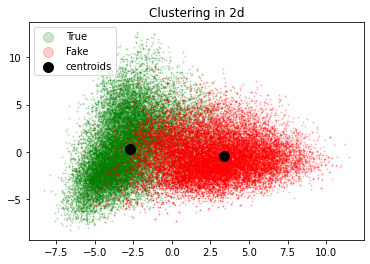

In [7]:
#2D Visualization
ax = plt.figure()
ax=ax.add_subplot()
ax.scatter(np.array(true)[:,0], np.array(true)[:,1], c='green', s=1, alpha=0.2, label="True")
ax.scatter(np.array(fake)[:,0], np.array(fake)[:,1], c='red', s=1, alpha=0.2, label="Fake")
ax.scatter(c[:, 0], c[:, 1], c='black', s=100, alpha=1, label="centroids");

leg = ax.legend(loc=2, prop={'size':10})
leg.legendHandles[0]._sizes = [100]
leg.legendHandles[1]._sizes = [100]
leg.legendHandles[2]._size = [100]


plt.title("Clustering in 2d")
plt.show()

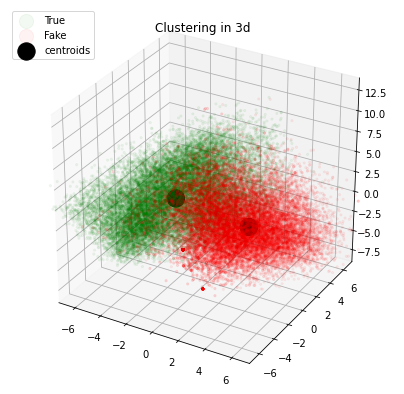

In [8]:
#3D Visualization
fig = plt.figure(figsize=(7, 7))
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(np.array(true)[:,0], np.array(true)[:,1],np.array(true)[:,2], c='green',label="True", s=5, alpha=0.05)
ax2.scatter(np.array(fake)[:,0], np.array(fake)[:,1],np.array(fake)[:,2], c='red', s=5,label="Fake", alpha=0.05)
ax2.scatter(c[:, 0], c[:, 1], c[:, 2],c='black', alpha=1,s=300,label = "centroids");
plt.xlim(-7,7)
plt.ylim(-7,7)

leg2 = ax2.legend(loc=2, prop={'size':10})
leg2.legendHandles[0]._sizes = [200]
leg2.legendHandles[1]._sizes = [200]
leg2.legendHandles[2]._size = [200]

plt.title("Clustering in 3d")
plt.show()

## Performance evaluation
### How did our clustering perform against the real labels?

We do have the true lables (fake/real), but we don't know which cluster correspond to which label. Therefore, we check the two options:

*   Define cluster 1 as fake and cluster 2 as real. What is the accuracy?
*   Define cluster 1 as true and cluster 2 as fake. What is the accuracy?

In [9]:
# Implement here

y_opposite_pred=[1 if i==0 else 0 for i in y_pred]

accuracy1 = accuracy_score(y_true,y_pred)
accuracy2 = accuracy_score(y_true,y_opposite_pred)

print('cluster 1 as fake and cluster 2 as real: accuracy: '+str(accuracy1))
print('cluster 1 as true and cluster 2 as fake: accuracy: '+str(accuracy2))

cluster 1 as fake and cluster 2 as real: accuracy: 0.8705510267717939
cluster 1 as true and cluster 2 as fake: accuracy: 0.12944897322820614


## Find optimal `k`
What is the best k for clustering?

* Cluster using a range of `k` (up to 20) and compare the SSD and the Silhouette values for every k.
* Plot SSD vs. k and Silhouette score vs. k.


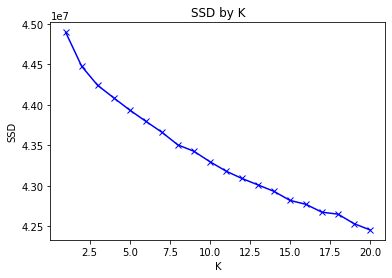

In [10]:
#SSD 

ssd = []

K = range(1, 21)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    ssd.append(kmeanModel.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('K')
plt.ylabel('SSD')
plt.title('SSD by K')
plt.show()

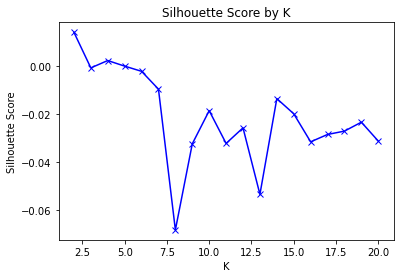

In [11]:
# Silhouette

Silhouette = []

K = range(2, 21)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    labels=kmeanModel.predict(X)
    Silhouette.append(silhouette_score(X,labels,sample_size=300))


plt.plot(K, Silhouette, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.show()

### What is the optimal k for clustering?

* Explain.
* If optimal k!=2 what can be a good explanation for this?

Explantion:

In the SSD algorithm, the point where the graph starts to be linear is the point with the best K - this phenomenon is called 'elbow'. In our SSD graph, there is an 'elbow' around the point K = 2. at this point, the graph approximately begins to be linear.


In the Silhouette algorithm, the maximum point(with maximum Silhouette Score) is the point with the best K. In our Silhouette graph in the range of 1-20 there is a maximum score at K = 2.
The best k for clustering is 2.

If optimal k!=2:

This case is possible because the data is not unequivocally divided into 2 groups. There can be additional and better divisions, for example, division by topics.

# PCA then k-means
This time, lets try to change the order.
1. Generate TF-IDF 1000 features
2. Run PCA
3. Run k-means
4. Plot 2D and 3D scatter plots
5. Estimate the accuracy according to true labels.
6. Explain how is it compared to the previous approach, where clustering is performed w/o PCA.


In [12]:
""" Answer """
#1. TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X3 = vectorizer.fit_transform(list(df['text'])).toarray()
y_true = list(df['label'])

scaler = StandardScaler(with_mean=False)
X3 = scaler.fit_transform(X3)

In [13]:
#2. PCA
XP = PCA().fit_transform(X3)


In [14]:
#3. K-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(XP)
y_kmeans_XP = kmeans.predict(XP)


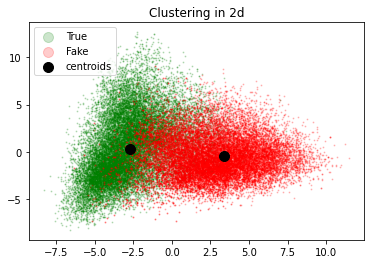

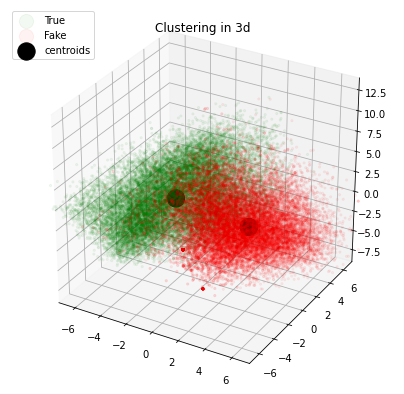

In [15]:
#4.
centers = kmeans.cluster_centers_

true = []
fake = []
for i in range(len(XP)):
  if y_true[i]==0:
    fake.append(XP[i])
  else:
    true.append(XP[i])

#2D
ax = plt.figure()
ax=ax.add_subplot()
ax.scatter(np.array(true)[:,0], np.array(true)[:,1], c='green', s=1, alpha=0.2, label="True")
ax.scatter(np.array(fake)[:,0], np.array(fake)[:,1], c='red', s=1, alpha=0.2, label="Fake")
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1, label="centroids");

leg = ax.legend(loc=2, prop={'size':10})
leg.legendHandles[0]._sizes = [100]
leg.legendHandles[1]._sizes = [100]
leg.legendHandles[2]._size = [100]


plt.title("Clustering in 2d")
plt.show()

#3D
fig = plt.figure(figsize=(7, 7))
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(np.array(true)[:,0], np.array(true)[:,1],np.array(true)[:,2], c='green',label="True", s=5, alpha=0.05)
ax2.scatter(np.array(fake)[:,0], np.array(fake)[:,1],np.array(fake)[:,2], c='red', s=5,label="Fake", alpha=0.05)
ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2],c='black', alpha=1,s=300,label = "centroids");
plt.xlim(-7,7)
plt.ylim(-7,7)

leg2 = ax2.legend(loc=2, prop={'size':10})
leg2.legendHandles[0]._sizes = [200]
leg2.legendHandles[1]._sizes = [200]
leg2.legendHandles[2]._size = [200]

plt.title("Clustering in 3d")
plt.show()

In [16]:
#5. accuracy according to true labels
accuracy = accuracy_score(y_true,y_kmeans_XP)
print(accuracy)

0.8704619359436946


6. There is no difference between the previous section and this section.

Explainion:

PCA transforms the data in the direction of the eigenvectors with the highest eigenvalues that are calculated from the covariance matrix. When we apply K-means with\without PCA before, we may get different results if the covariance of the features is high. The accuracy is similar in both parts(with\without PCA) i.e the covariance of the features is not high enough to change the results.



